# Assignment 2

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

In [2]:
train_a = np.loadtxt("hwk2data/classificationA.train")
train_b = np.loadtxt("hwk2data/classificationB.train") 
train_c = np.loadtxt("hwk2data/classificationC.train")
test_a = np.loadtxt("hwk2data/classificationA.test")
test_b = np.loadtxt("hwk2data/classificationB.test")
test_c = np.loadtxt("hwk2data/classificationC.test")

## Question 1.c) LDA

We first define helper functions which will be used to compute throughout the notebook. One implements the sigmoid function and the other is a plotting function based on the models in this notebook.

In [3]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [4]:
def plot_decision_boundary(features,labels, model, figure_path, title,n_points = 1000, scale = 1):

    xlim = min(features[:,0])*scale, max(features[:,0]*scale)
    ylim = min(features[:,1]*scale), max(features[:,1]*scale)

    xx = np.linspace(xlim[0],xlim[1], n_points)
    yy = np.linspace(ylim[0],ylim[1], n_points)

    X,Y = np.meshgrid(xx,yy)
    points = np.transpose(np.array([X.flatten(), Y.flatten()]))
    
    
    fig = plt.figure(figsize = (10,10))
    plt.title(title)
    plt.scatter(features[:,0], features[:,1], c = labels)
    CS = plt.contour(X,Y, np.reshape(model.predict(points), (n_points,n_points)), levels = [0.5])
    plt.clabel(CS, inline=1, fontsize=10)
    fig.savefig(figure_path)
    plt.show()

Now we define the LDA model as a class, where the train method implements the MLE for each parameter.

In [5]:
class LDA:
    
    def __init__(self, d):
        """
        Constructor.
        Arguments:
            d - dimension of training point.
        """
        self.d = d
        
        #Initialize parameters with placeholders
        self.mu_1 = np.ones(shape = (d,1))
        self.mu_0 = np.ones(shape = (d,1))
        self.pi = 0
        self.sigma = np.ones(shape = (d,d))
        
        
        
    def train(self, data):
        
        """
        Compute LDA parameters following MLE.
        
        Arguments:
            Training data of the form of the training sets provided.
        
        """
        y_ = data[:,-1]
        x_ = data[:,:-1]
        n = data.shape[0]
        
        #compute mu_1
        self.mu_1 = (1/(np.sum(y_)))*(np.sum([y_[i]*x_[i,:] for i in range(y_.shape[0])],axis = 0))
        self.mu_1 = np.reshape(self.mu_1, newshape=(self.d,1))
        
        
        #compute mu_0
        self.mu_0 = (1/(np.sum(1-y_)))*(np.sum([(1-y_[i])*x_[i,:] for i in range(y_.shape[0])], axis = 0))
        self.mu_0 = np.reshape(self.mu_0, newshape=(self.d,1))
        
        
        #compute pi
        self.pi = np.sum(y_)/n
        
        #compute sigma
        mat_1 = np.zeros(shape = (self.d,self.d)) 
        mat_0 = np.zeros(shape = (self.d,self.d))
        for i in range(n):
            y = y_[i]
            x = x_[i,:].reshape(self.d,1)
            mat_1 = mat_1 + y*((x-self.mu_1) @ (np.transpose(x-self.mu_1)))

        sigma_tilde_1 = (1/n)*(mat_1)

         
        for i in range(n):
            y = y_[i]
            x = x_[i,:].reshape(self.d,1)
            mat_0 = mat_0 + (1-y)*((x-self.mu_0) @ (np.transpose(x-self.mu_0)))

        sigma_tilde_0 = (1/n)*(mat_0)

        self.sigma = (sigma_tilde_1 + sigma_tilde_0)
        

    
    def predict(self, test_data):
        """
        Compute predicted labels on test data.
        Arguments:
            test_data - Test data matrix of dimension m x d.
            
        Returns:
            predictions - Vector of predicted labels of dimension m.
        """
        
        inv_sigma = np.linalg.inv(self.sigma)
        w = inv_sigma @ (self.mu_1-self.mu_0)
        b = -0.5*(np.transpose(self.mu_1-self.mu_0) @ inv_sigma @ (self.mu_1+self.mu_0)) + np.log(self.pi/(1-self.pi))
        
        predictions = sigmoid((test_data @ w) + b)[:,0]
        
        return predictions

Now we can go ahead and plot the three decision functions over each training set corresponding to the conditional distribution $p(y=1|x)$. To do so, we first train each model and then call the above plotting function on each dataset.

In [6]:
#Instantiate our models
lda_model_a = LDA(d = train_a[:,:-1].shape[1])
lda_model_b = LDA(d = train_b[:,:-1].shape[1])
lda_model_c = LDA(d = train_c[:,:-1].shape[1])

#Train the models
lda_model_a.train(train_a)
lda_model_b.train(train_b)
lda_model_c.train(train_c)

#### Train A point cloud and decision function

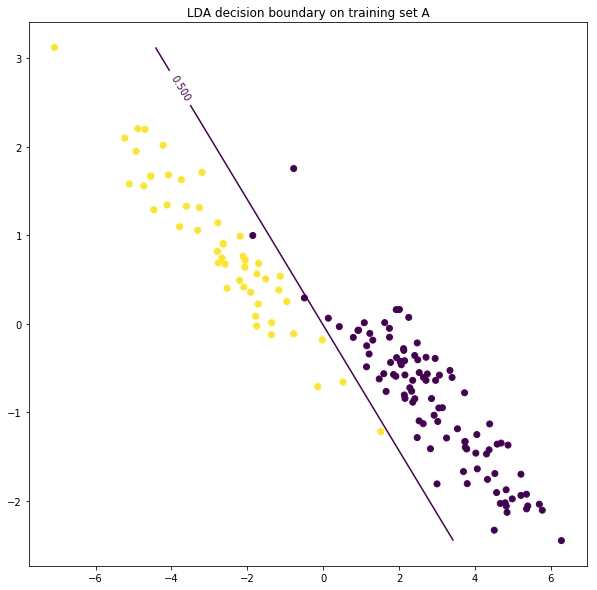

In [7]:
plot_decision_boundary(train_a[:,:-1],train_a[:,-1], lda_model_a,"Figures/q1traina", "LDA decision boundary on training set A" )

#### Train B point cloud and decision function

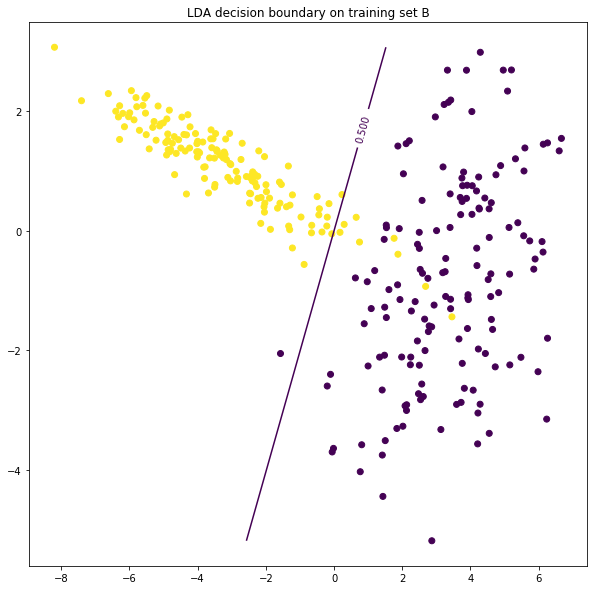

In [8]:
plot_decision_boundary(train_b[:,:-1],train_b[:,-1], lda_model_b,"Figures/q1trainb", "LDA decision boundary on training set B" )

#### Train C point cloud and decision function

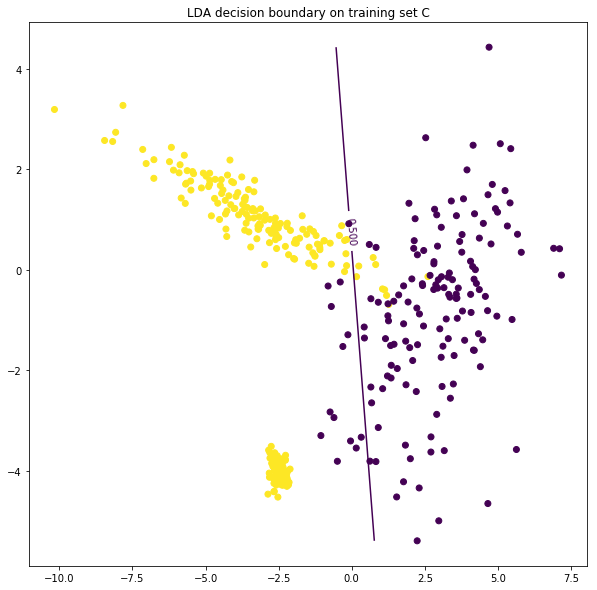

In [9]:
plot_decision_boundary(train_c[:,:-1],train_c[:,-1], lda_model_c,"Figures/q1trainc", "LDA decision boundary on training set C" )

## Question 2 : Logistic Regression

We first implement the class for logistic regression which implements the IRLS algorithm for training. According to class notes, we will be using the same notation and lettering within the code.

In [10]:
class LogisticRegression:
    def __init__(self, d):
            
        """
        Constructor.
        Arguments: 
            d - dimension of feature vector
        """
        
        self.d = d+1 #We assume the feature vector does not include the bias, so we add it here
        self.weights = np.array([np.random.normal()*0.01, np.random.normal()*0.01, 0]) #Set initial weights to small random values
        
    def train(self, train_features, train_labels):
        
        """
        Compute weight parameters.
        
        Arguments:
            train_features - Design matrix of dimension n x d.
            train_labels - target label vector of dimension n.
        
        """
        #Add a column of ones to the design matrix, thus implementing bias trick
        train_features = np.append(train_features, np.ones(shape = (train_features.shape[0],1)), axis = 1)
        
        
        while True: #Continue until break
            
            #Compute values for IRLS
            mu = sigmoid(train_features @ self.weights)
           
            #Check convergence
            grad = np.transpose(train_features) @ (train_labels - mu)
            if (np.linalg.norm(grad)) < 0.00001 : break

            #Diagonal matrix
            d_vec = [x*(1-x) for x in mu]
            
            D = np.diag(d_vec)
            
            #Hessian
            H = np.transpose(train_features) @ D @ train_features

            #Compute Diagonal inverse matrix, check non-zero values
            inv_D = np.diag([1/x for x in d_vec if x!=0]) 

            #We consider zero values in the diagonal a convergence point.
            if inv_D.shape != (train_labels.shape[0], train_labels.shape[0]):
                break

            #target form
            Z = (train_features @ self.weights) + inv_D @ (train_labels - mu) 

            #According to hint, solve linear system to find new_w, since inverse of Hessian is not numerically stable
            #Solves the system Hw = X^{T}DZ.
            new_w = np.linalg.solve(H, (np.transpose(train_features) @ D @ Z) )

            self.weights = new_w

    
    def predict(self, test_features):
        """
        Compute predicted labels on test data.
        Arguments:
            test_features - Test data matrix of dimension m x d.
            
        Returns:
            predictions - Vector of predicted labels of dimension m.
        """ 
        #Add a column of ones to the test data matrix, thus implementing bias trick
        test_features = np.append(test_features, np.ones(shape = (test_features.shape[0],1)), axis = 1)
        
        predictions = sigmoid((test_features @ self.weights))
        
        return predictions
        

#### Part a)

The values of  the parameters are given below for each training set.

In [11]:
#Instantiate our models
log_reg_model_a = LogisticRegression(d = train_a[:,:-1].shape[1])
log_reg_model_b = LogisticRegression(d = train_b[:,:-1].shape[1])
log_reg_model_c = LogisticRegression(d = train_c[:,:-1].shape[1])

#Train the models
log_reg_model_a.train(train_features = train_a[:,:-1], train_labels = train_a[:,-1])
log_reg_model_b.train(train_features = train_b[:,:-1], train_labels = train_b[:,-1])
log_reg_model_c.train(train_features = train_c[:,:-1], train_labels = train_c[:,-1])

#print learned parameters
print("Training set A weights : ", log_reg_model_a.weights)
print("Training set B weights : ", log_reg_model_b.weights)
print("Training set C weights : ", log_reg_model_c.weights)

Training set A weights :  [-25.14441494 -42.68381698  -4.80860223]
Training set B weights :  [-1.70518567  1.02378525  1.34959131]
Training set C weights :  [-2.20323226  0.70926552  0.95918875]


#### Part b)

We now present the obtained decision boundaries for each training set. 

#### Train A point cloud and decision function

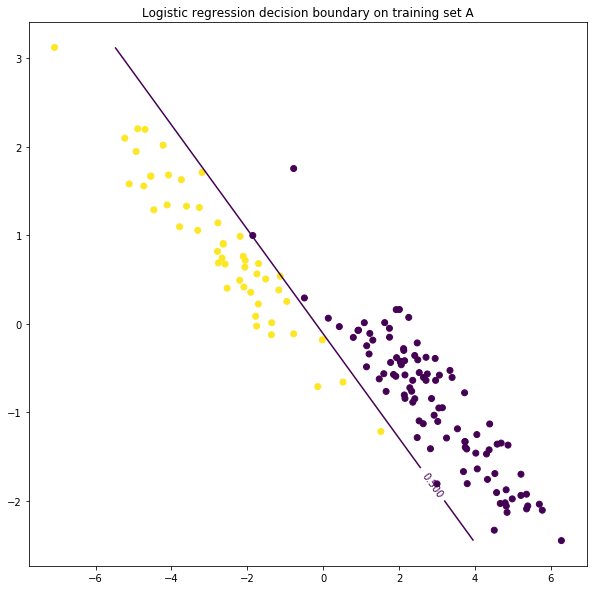

In [12]:
plot_decision_boundary(train_a[:,:-1],train_a[:,-1], log_reg_model_a,"Figures/q2traina", "Logistic regression decision boundary on training set A" )

#### Train B point cloud and decision function

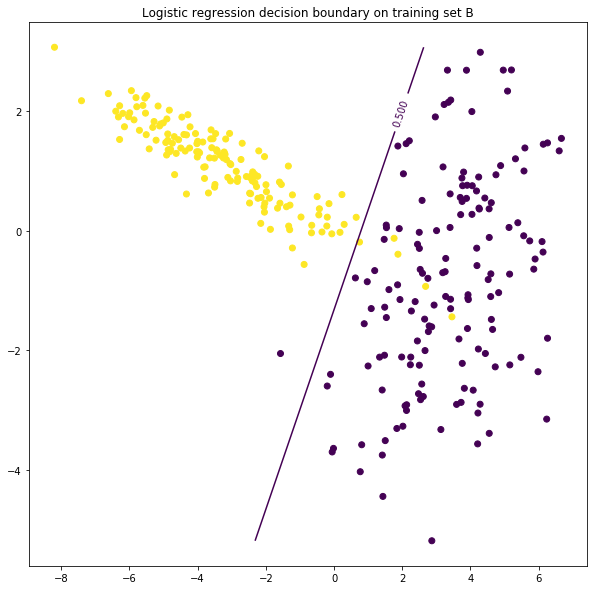

In [13]:
plot_decision_boundary(train_b[:,:-1],train_b[:,-1], log_reg_model_b,"Figures/q2trainb", "Logistic regression decision boundary on training set B" )

#### Train C point cloud and decision function

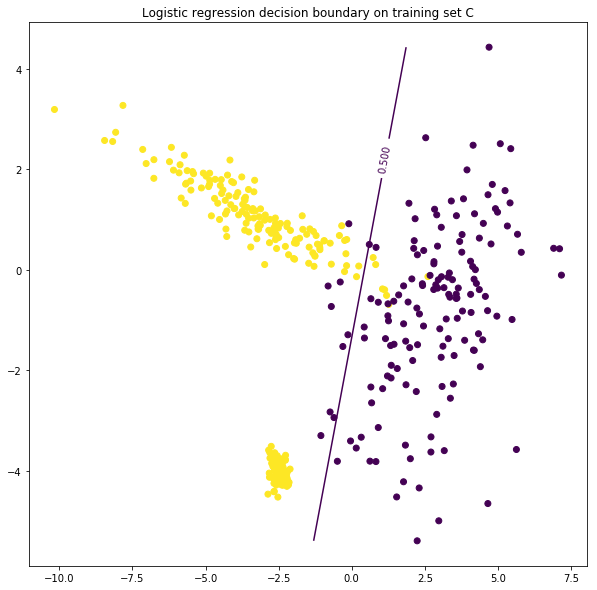

In [14]:
plot_decision_boundary(train_c[:,:-1],train_c[:,-1], log_reg_model_c,"Figures/q2trainc", "Logistic regression decision boundary on training set C" )

## Question 3 : Linear Regression

We implement below the class corresponding to unregularized linear regression. The implementation assumes that the solution can be found using the normal equation, and thus that the matrix $X^{T}X$ is invertible. The solution to the normal equation is given by:

$$ w^{*} = (X^{T}X)^{-1}X^{T}y $$

In [15]:
class LinearRegression:
    def __init__(self, d):
        """
        Constructor.
        Arguments: 
            d - dimension of feature vector
        """
        
        self.d = d+1 #We assume the feature vector does not include the bias, so we add it here
        self.weights = np.ones(shape = (self.d,1)) #Set initial weights to 1 as placeholders
        
    def train(self, train_features, train_labels):
        """
        Compute weight parameters.
        
        Arguments:
            train_features - Design matrix of dimension n x d.
            train_labels - target label vector of dimension n.
        
        """
        #Add a column of ones to the design matrix, thus implementing bias trick
        train_features = np.append(train_features, np.ones(shape = (train_features.shape[0],1)), axis = 1)
        
        #Solve for weights analytically from normal equation solution.
        self.weights = (np.linalg.inv(np.transpose(train_features) @ train_features)) @ (np.transpose(train_features) @ train_labels)
    
    def predict(self, test_features):
        """
        Compute predicted labels on test data.
        Arguments:
            test_features - Test data matrix of dimension m x d.
            
        Returns:
            predictions - Vector of predicted labels of dimension m.
        """ 
        #Add a column of ones to the test data matrix, thus implementing bias trick
        test_features = np.append(test_features, np.ones(shape = (test_features.shape[0],1)), axis = 1)
        
        #Computes real_valued predictions
        predictions= (test_features @ self.weights)
        
        
        return predictions
        

#### Part a)

Given the class definition, we may now train our models and obtain the learned weight parameters.

In [16]:
#Instantiate our models
lin_reg_model_a = LinearRegression(d = train_a[:,:-1].shape[1])
lin_reg_model_b = LinearRegression(d = train_b[:,:-1].shape[1])
lin_reg_model_c = LinearRegression(d = train_c[:,:-1].shape[1])

#Train the models
lin_reg_model_a.train(train_features = train_a[:,:-1], train_labels = train_a[:,-1])
lin_reg_model_b.train(train_features = train_b[:,:-1], train_labels = train_b[:,-1])
lin_reg_model_c.train(train_features = train_c[:,:-1], train_labels = train_c[:,-1])

#print learned parameters
print("Training set A weights : ", lin_reg_model_a.weights)
print("Training set B weights : ", lin_reg_model_b.weights)
print("Training set C weights : ", lin_reg_model_c.weights)

Training set A weights :  [-0.2640075  -0.37259311  0.49229204]
Training set B weights :  [-0.10424575  0.05179118  0.50005043]
Training set C weights :  [-0.12769333 -0.01700142  0.50839982]


#### Part b)

Now we can go ahead and plot the decision boundaries corresponding to the line $w^{T}x = 0.5$.

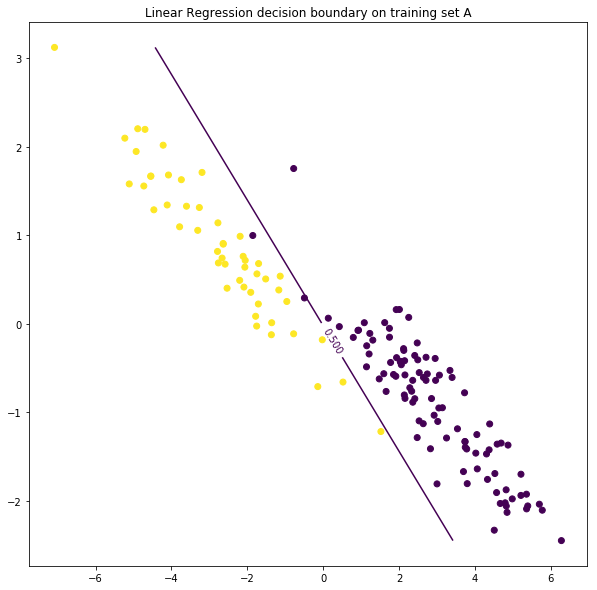

In [17]:
plot_decision_boundary(train_a[:,:-1], train_a[:,-1], lin_reg_model_a, "Figures/q3traina", "Linear Regression decision boundary on training set A")

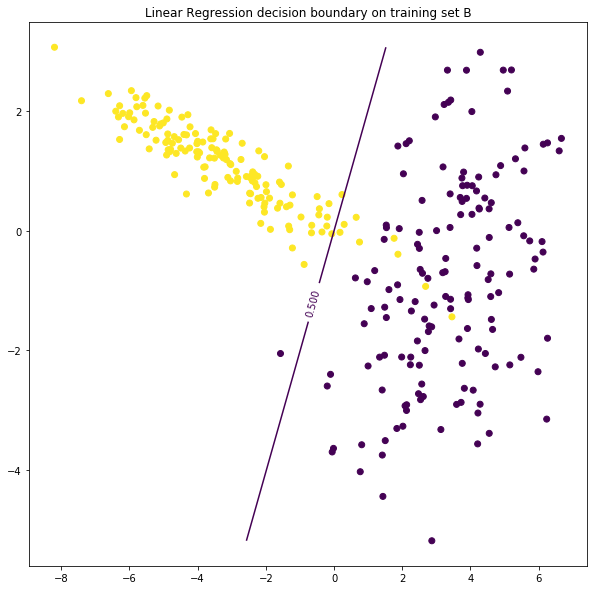

In [18]:
plot_decision_boundary(train_b[:,:-1], train_b[:,-1], lin_reg_model_b, "Figures/q3trainb", "Linear Regression decision boundary on training set B")

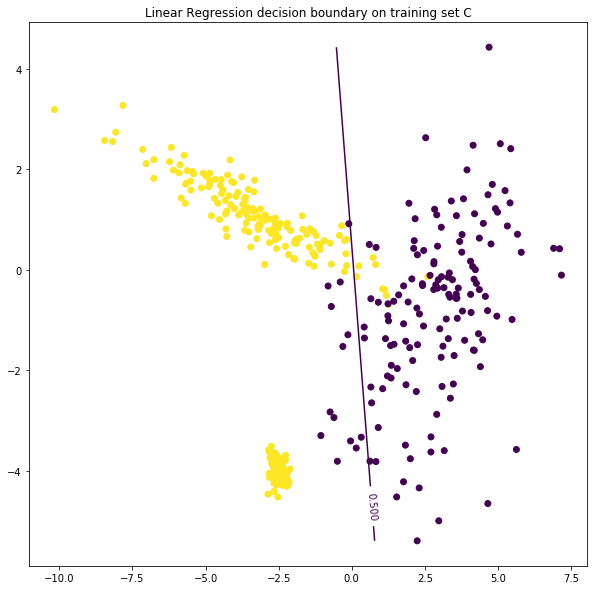

In [19]:
plot_decision_boundary(train_c[:,:-1], train_c[:,-1], lin_reg_model_c, "Figures/q3trainc", "Linear Regression decision boundary on training set C")

## Question 4

We define a function which takes as input a trained model along with data and returns the classification error as a percentage rounded to 2 decimal points on that data. The subsequent analysis can be found in the main pdf document.

In [20]:
def compute_error(model, features, labels):
    predicted_labels = model.predict(features)
    predicted_labels = (predicted_labels > 0.5)*1.0 #Convert booleans to 1,0
    correct = np.sum((predicted_labels == labels)*1.0)
    return 1-(correct/labels.shape[0])

In [21]:
#Compute training and test errors for each dataset with LDA model

lda_error_train_a = compute_error(lda_model_a,train_a[:,:-1], train_a[:,-1])
lda_error_test_a = compute_error(lda_model_a,test_a[:,:-1], test_a[:,-1])
lda_error_train_b = compute_error(lda_model_b,train_b[:,:-1], train_b[:,-1])
lda_error_test_b = compute_error(lda_model_b,test_b[:,:-1], test_b[:,-1])
lda_error_train_c = compute_error(lda_model_c,train_c[:,:-1], train_c[:,-1])
lda_error_test_c = compute_error(lda_model_c,test_c[:,:-1], test_c[:,-1])

print("The training error for the LDA model on training dataset A is: {:0.2f}".format(lda_error_train_a*100), "%")
print("The testing error for the LDA model on testing dataset A is: {:0.2f}".format(lda_error_test_a*100), "%")
print("The training error for the LDA model on training dataset B is: {:0.2f}".format(lda_error_train_b*100), "%")
print("The testing error for the LDA model on testing dataset B is: {:0.2f}".format(lda_error_test_b*100), "%")
print("The training error for the LDA model on training dataset C is: {:0.2f}".format(lda_error_train_c*100), "%")
print("The testing error for the LDA model on testing dataset c is: {:0.2f}".format(lda_error_test_c*100), "%")

The training error for the LDA model on training dataset A is: 1.33 %
The testing error for the LDA model on testing dataset A is: 2.00 %
The training error for the LDA model on training dataset B is: 3.00 %
The testing error for the LDA model on testing dataset B is: 4.15 %
The training error for the LDA model on training dataset C is: 5.50 %
The testing error for the LDA model on testing dataset c is: 4.23 %


In [22]:
#Compute training and test errors for each dataset with Logistic Regression model

logreg_error_train_a = compute_error(log_reg_model_a,train_a[:,:-1], train_a[:,-1])
logreg_error_test_a = compute_error(log_reg_model_a,test_a[:,:-1], test_a[:,-1])
logreg_error_train_b = compute_error(log_reg_model_b,train_b[:,:-1], train_b[:,-1])
logreg_error_test_b = compute_error(log_reg_model_b,test_b[:,:-1], test_b[:,-1])
logreg_error_train_c = compute_error(log_reg_model_c,train_c[:,:-1], train_c[:,-1])
logreg_error_test_c = compute_error(log_reg_model_c,test_c[:,:-1], test_c[:,-1])

print("The training error for the Logistic Regression model on training dataset A is: {:0.2f}".format(logreg_error_train_a*100),"%")
print("The testing error for the Logistic Regression model on testing dataset A is: {:0.2f}".format(logreg_error_test_a*100),"%")
print("The training error for the Logistic Regression model on training dataset B is: {:0.2f}".format(logreg_error_train_b*100),"%")
print("The testing error for the Logistic Regression model on testing dataset B is: {:0.2f}".format(logreg_error_test_b*100),"%")
print("The training error for the Logistic Regression model on training dataset C is: {:0.2f}".format(logreg_error_train_c*100),"%")
print("The testing error for the Logistic Regression model on testing dataset c is: {:0.2f}".format(logreg_error_test_c*100),"%")

The training error for the Logistic Regression model on training dataset A is: 0.00 %
The testing error for the Logistic Regression model on testing dataset A is: 3.53 %
The training error for the Logistic Regression model on training dataset B is: 2.00 %
The testing error for the Logistic Regression model on testing dataset B is: 4.30 %
The training error for the Logistic Regression model on training dataset C is: 4.00 %
The testing error for the Logistic Regression model on testing dataset c is: 2.27 %


In [23]:
#Compute training and test errors for each dataset with Linear Regression model

linreg_error_train_a = compute_error(lin_reg_model_a,train_a[:,:-1], train_a[:,-1])
linreg_error_test_a = compute_error(lin_reg_model_a,test_a[:,:-1], test_a[:,-1])
linreg_error_train_b = compute_error(lin_reg_model_b,train_b[:,:-1], train_b[:,-1])
linreg_error_test_b = compute_error(lin_reg_model_b,test_b[:,:-1], test_b[:,-1])
linreg_error_train_c = compute_error(lin_reg_model_c,train_c[:,:-1], train_c[:,-1])
linreg_error_test_c = compute_error(lin_reg_model_c,test_c[:,:-1], test_c[:,-1])

print("The training error for the Linear Regression model on training dataset A is: {:0.2f}".format(linreg_error_train_a*100),"%")
print("The testing error for the Linear Regression model on testing dataset A is: {:0.2f}".format(linreg_error_test_a*100),"%")
print("The training error for the Linear Regression model on training dataset B is: {:0.2f}".format(linreg_error_train_b*100),"%")
print("The testing error for the Linear Regression model on testing dataset B is: {:0.2f}".format(linreg_error_test_b*100),"%")
print("The training error for the Linear Regression model on training dataset C is: {:0.2f}".format(linreg_error_train_c*100),"%")
print("The testing error for the Linear Regression model on testing dataset c is: {:0.2f}".format(linreg_error_test_c*100),"%")

The training error for the Linear Regression model on training dataset A is: 1.33 %
The testing error for the Linear Regression model on testing dataset A is: 2.07 %
The training error for the Linear Regression model on training dataset B is: 3.00 %
The testing error for the Linear Regression model on testing dataset B is: 4.15 %
The training error for the Linear Regression model on training dataset C is: 5.50 %
The testing error for the Linear Regression model on testing dataset c is: 4.23 %


## Question 5

As before, we begin by defining our class for QDA according to the MLE.

In [24]:
class QDA:
    
    def __init__(self, d):
        """
        Constructor.
        Arguments:
            d - dimension of training point.
        """
        self.d = d
        
        #Initialize parameters with placeholders
        self.mu_1 = np.ones(shape = (d,1))
        self.mu_0 = np.ones(shape = (d,1))
        self.pi = 0
        self.sigma_1 = np.ones(shape = (d,d))
        self.sigma_0 = np.ones(shape = (d,d))
        
        
        
    def train(self, data):
        
        """
        Compute LDA parameters following MLE.
        
        Arguments:
            Training data of the form of the training sets provided.
        
        """
        y_ = data[:,-1]
        x_ = data[:,:-1]
        n = data.shape[0]
        
        #compute mu_1
        self.mu_1 = (1/(np.sum(y_)))*(np.sum([y_[i]*x_[i,:] for i in range(y_.shape[0])],axis = 0))
        self.mu_1 = np.reshape(self.mu_1, newshape=(self.d,1))
        
        
        #compute mu_0
        self.mu_0 = (1/(np.sum(1-y_)))*(np.sum([(1-y_[i])*x_[i,:] for i in range(y_.shape[0])], axis = 0))
        self.mu_0 = np.reshape(self.mu_0, newshape=(self.d,1))
        
        
        #compute pi
        self.pi = np.sum(y_)/n
        
        #compute sigma_1
        mat_1 = np.zeros(shape = (self.d,self.d)) 
        for i in range(n):
            y = y_[i]
            x = x_[i,:].reshape(self.d,1)
            mat_1 = mat_1 + y*((x-self.mu_1) @ (np.transpose(x-self.mu_1)))

        sigma_tilde_1 = mat_1
        self.sigma_1 = (1/np.sum(y_))*(sigma_tilde_1)

         
        #compute sigma_0
        mat_0 = np.zeros(shape = (self.d,self.d))
        for i in range(n):
            y = y_[i]
            x = x_[i,:].reshape(self.d,1)
            mat_0 = mat_0 + (1-y)*((x-self.mu_0) @ (np.transpose(x-self.mu_0)))

        sigma_tilde_0 = mat_0
        self.sigma_0 = (1/np.sum(1-y_))*(sigma_tilde_0)
        

    
    def predict(self, test_data):
        """
        Compute predicted labels on test data.
        Arguments:
            test_data - Test data matrix of dimension m x d.
            
        Returns:
            predictions - Vector of predicted labels of dimension m.
        """
        
        inv_sigma_1 = np.linalg.inv(self.sigma_1)
        inv_sigma_0 = np.linalg.inv(self.sigma_0)
        
        exponent = (np.array([0.5*( np.transpose(test_data[i,:] - self.mu_1[:,0])@ inv_sigma_1 @(test_data[i,:] - self.mu_1[:,0] )) 
                              -0.5*(np.transpose(test_data[i,:] - self.mu_0[:,0])@ inv_sigma_0 @(test_data[i,:] - self.mu_0[:,0]))
                              -np.log(self.pi/(1-self.pi)) for i in range(test_data.shape[0])]))
        
        predictions = 1/(1+ np.exp(exponent))
        
        return predictions

#### Part a)

We can now proceed to define our models and train them on each dataset. We then output the parameters for each model.

In [25]:
#Instantiate our models
qda_model_a = QDA(d = train_a[:,:-1].shape[1])
qda_model_b = QDA(d = train_b[:,:-1].shape[1])
qda_model_c = QDA(d = train_c[:,:-1].shape[1])

#Train the models
qda_model_a.train(train_a)
qda_model_b.train(train_b)
qda_model_c.train(train_c)

#print learned parameters
print("Training set A --------------------------\n Sigma 1:", qda_model_a.sigma_1, "\n",
      "Sigma 0:", qda_model_a.sigma_0, "\n",
      "mu 1:", qda_model_a.mu_1,"\n",
      "mu 0:", qda_model_a.mu_0,"\n",
      "pi:" ,qda_model_a.pi)
                                                    
print("Training set B --------------------------\n Sigma 1:", qda_model_b.sigma_1, "\n",
      "Sigma 0:", qda_model_b.sigma_0, "\n",
      "mu 1:", qda_model_b.mu_1,"\n",
      "mu 0:", qda_model_b.mu_0,"\n",
      "pi:" ,qda_model_b.pi)
print("Training set C --------------------------\n Sigma 1:", qda_model_c.sigma_1, "\n",
      "Sigma 0:", qda_model_c.sigma_0, "\n",
      "mu 1:", qda_model_c.mu_1,"\n",
      "mu 0:", qda_model_c.mu_0,"\n",
      "pi:" ,qda_model_c.pi)

Training set A --------------------------
 Sigma 1: [[ 2.70442172 -1.3008515 ]
 [-1.3008515   0.68969588]] 
 Sigma 0: [[ 2.31065259 -1.04748461]
 [-1.04748461  0.57578403]] 
 mu 1: [[-2.69232004]
 [ 0.866042  ]] 
 mu 0: [[ 2.89970947]
 [-0.893874  ]] 
 pi: 0.3333333333333333
Training set B --------------------------
 Sigma 1: [[ 4.15361075 -1.33454097]
 [-1.33454097  0.51607059]] 
 Sigma 0: [[2.53885859 1.0642112 ]
 [1.0642112  2.96007891]] 
 mu 1: [[-3.21670734]
 [ 1.08306733]] 
 mu 0: [[ 3.34068896]
 [-0.83546333]] 
 pi: 0.5
Training set C --------------------------
 Sigma 1: [[ 2.86914403 -1.76197061]
 [-1.76197061  6.56438626]] 
 Sigma 0: [[2.89913927 1.24581553]
 [1.24581553 2.92475448]] 
 mu 1: [[-2.94232885]
 [-0.9578284 ]] 
 mu 0: [[ 2.79304824]
 [-0.83838667]] 
 pi: 0.625


#### Part b)

As before, we can print our decision boundaries one by one.

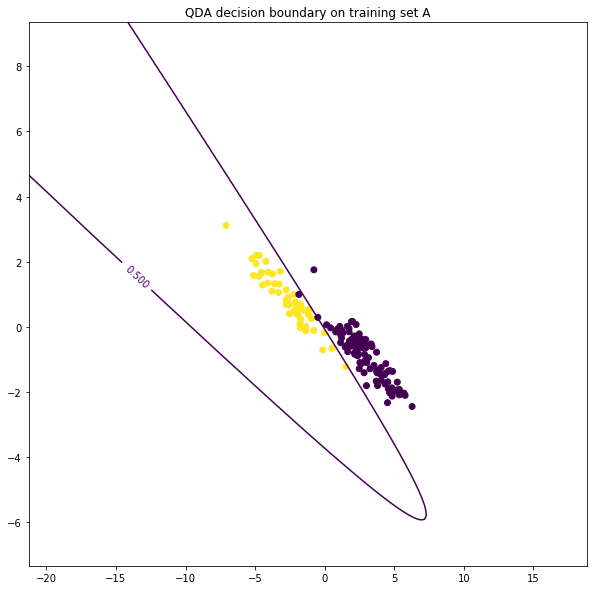

In [26]:
(plot_decision_boundary(train_a[:,:-1],train_a[:,-1], qda_model_a,"Figures/q5traina", 
                        "QDA decision boundary on training set A",n_points = 200,scale=3 ))

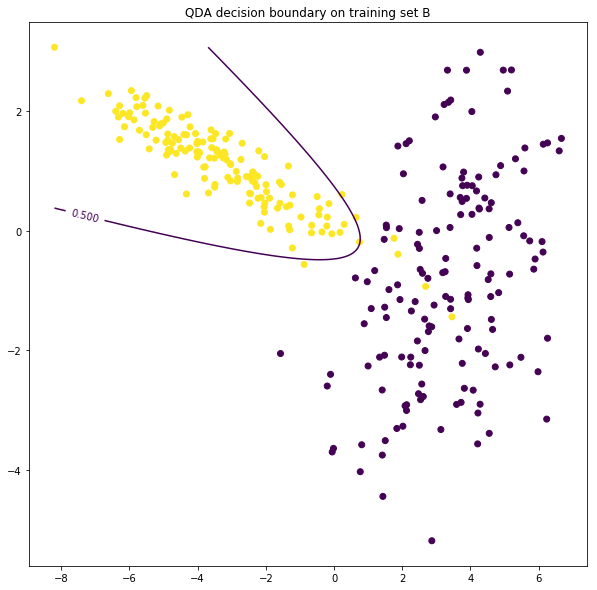

In [27]:
(plot_decision_boundary(train_b[:,:-1],train_b[:,-1], qda_model_b,"Figures/q5trainb", 
                        "QDA decision boundary on training set B",n_points = 200))

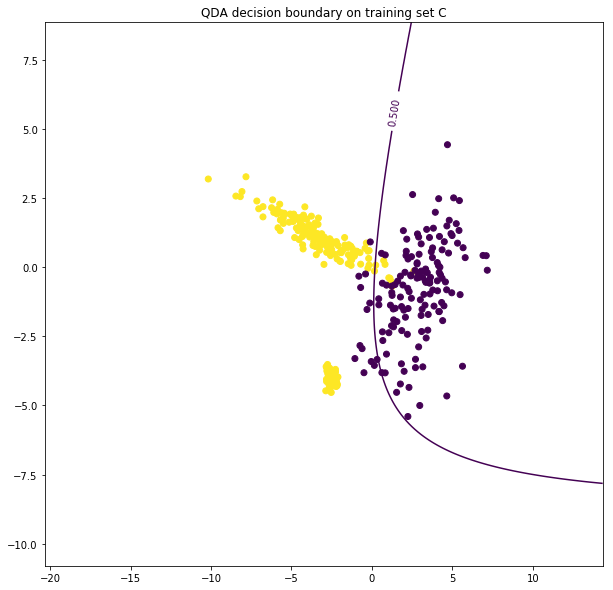

In [28]:
(plot_decision_boundary(train_c[:,:-1],train_c[:,-1], qda_model_c,"Figures/q5trainc", 
                        "QDA decision boundary on training set C",n_points = 200,scale = 2))

#### Part c)

Finally, we can go ahead as before and compute our classification performance on this model. The completed results table is found within the pdf document.

In [29]:
#Compute training and test errors for each dataset with Linear Regression model

qda_error_train_a = compute_error(qda_model_a,train_a[:,:-1], train_a[:,-1])
qda_error_test_a = compute_error(qda_model_a,test_a[:,:-1], test_a[:,-1])
qda_error_train_b = compute_error(qda_model_b,train_b[:,:-1], train_b[:,-1])
qda_error_test_b = compute_error(qda_model_b,test_b[:,:-1], test_b[:,-1])
qda_error_train_c = compute_error(qda_model_c,train_c[:,:-1], train_c[:,-1])
qda_error_test_c = compute_error(qda_model_c,test_c[:,:-1], test_c[:,-1])

print("The training error for the QDA model on training dataset A is: {:0.2f}".format(qda_error_train_a*100),"%")
print("The testing error for the QDA model on testing dataset A is: {:0.2f}".format(qda_error_test_a*100),"%")
print("The training error for the QDA model on training dataset B is: {:0.2f}".format(qda_error_train_b*100),"%")
print("The testing error for the QDA model on testing dataset B is: {:0.2f}".format(qda_error_test_b*100),"%")
print("The training error for the QDA model on training dataset C is: {:0.2f}".format(qda_error_train_c*100),"%")
print("The testing error for the QDA model on testing dataset c is: {:0.2f}".format(qda_error_test_c*100),"%")

The training error for the QDA model on training dataset A is: 0.67 %
The testing error for the QDA model on testing dataset A is: 1.87 %
The training error for the QDA model on training dataset B is: 2.33 %
The testing error for the QDA model on testing dataset B is: 2.35 %
The training error for the QDA model on training dataset C is: 5.25 %
The testing error for the QDA model on testing dataset c is: 4.03 %
